# CIFAR-10 task with ConvNet bias neuron



In [3]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.transforms as transforms
from torch.autograd import Variable
from binarized_modules import  BinarizeLinear, BinarizeConv2d
from binarized_modules import  Binarize
import numpy as np
import math
from scipy.stats import binom
import torchvision
from utils import *

import matplotlib.pyplot as plt

In [21]:
#Loading the dataset and defining the data augmentations

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=200, shuffle=False)

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1000, shuffle=True)
trainloader_tested = torch.utils.data.DataLoader(trainset, batch_size=200, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


For the ConvNet simulations we first train our model on the CIFAR-10 dataset, and save the model as "VGG_trained_model". In this notebook, we define the same model but with the circuit-based implementations. Then load the same model into it.  

In [22]:
# Defining the testing function
def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    train_loss = 0
    correct_test = 0
    correct_train = 0
    total_train = 0
    total_test = 0
    with torch.no_grad():

        for batch_idx, (inputs, targets) in enumerate(trainloader_tested):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total_train += targets.size(0)
            correct_train += predicted.eq(targets).sum().item()

        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total_test += targets.size(0)
            correct_test += predicted.eq(targets).sum().item()

    acc_train = 100.*correct_train/total_train
    acc_test = 100.*correct_test/total_test
    # Append accuracy
    print('%.3f' % acc_test + ', %.3f' % acc_train + ', %.5f' % train_loss)
    test_acc_list.append(acc_test)
    return acc_test, acc_train

In [23]:
#Setting up the GPU
gpu = 1 #GPU position
device = get_default_device(gpu) #set the device (returns cpu if no gpu is available)

NVIDIA TITAN RTX


# Testing

In [24]:
#Defining the neural network model with the circuit-based implementations
class VGG_with_bias_neurons(nn.Module):
    def __init__(self):
        super(VGG_with_bias_neurons, self).__init__()
        

        self.bCov1 = BinarizeConv2d(3, 385, kernel_size=3, stride=1, padding=1,bias=True)
        self.bn1 = nn.BatchNorm2d(385, affine=False)
        self.htan1 = nn.Hardtanh(inplace=True)

        self.bCov2 = BinarizeConv2d(385, 385, kernel_size=3, padding=1, bias=True)
        self.bn2 = nn.BatchNorm2d(385, affine=False)
        self.mp2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.htan2 = nn.Hardtanh(inplace=True)


        self.bCov3 = BinarizeConv2d(385, 769, kernel_size=3, padding=1, bias=True)
        self.bn3 = nn.BatchNorm2d(769, affine=False)
        self.htan3 = nn.Hardtanh(inplace=True)


        self.bCov4 = BinarizeConv2d(769, 769, kernel_size=3, padding=1, bias=True)
        self.bn4 = nn.BatchNorm2d(769, affine=False)
        self.mp4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.htan4 = nn.Hardtanh(inplace=True)


        self.bCov5 = BinarizeConv2d(769, 1537, kernel_size=3, padding=1, bias=True)
        self.bn5 = nn.BatchNorm2d(1537, affine=False)
        self.htan5 = nn.Hardtanh(inplace=True)


        self.bCov6 = BinarizeConv2d(1537, 513, kernel_size=3, padding=1, bias=True)
        self.bn6 = nn.BatchNorm2d(513, affine=False)
        self.mp6 = nn.MaxPool2d(kernel_size=2, stride=1)
        self.htan6 = nn.Hardtanh(inplace=True)

        
        self.fc7 = BinarizeLinear(513 * 7 * 7, 1025, bias=True)
        self.bn7 = nn.BatchNorm1d(1025, affine=False)
        self.htan7 = nn.Hardtanh(inplace=True)

        self.fc8 = BinarizeLinear(1025, 1025, bias=True)
        self.bn8 = nn.BatchNorm1d(1025, affine=False)
        self.htan8 = nn.Hardtanh(inplace=True)

        self.fc9 = BinarizeLinear(1025, 10, bias=True)
        self.bn9 = nn.BatchNorm1d(10, affine=False)

    def forward(self, x):
        
        x = self.bCov1(x)
        x = self.bn1(x)
        x = self.htan1(x)

        x = self.bCov2(x)
        x = self.mp2(x)
        x = BiasNeuron(device=device, inpt=x, N=3465, err=torch.tensor(err_3465), th=net.bn2.running_mean.view(1, -1, 1, 1))
        x = self.htan2(x)
        

        x = self.bCov3(x)
        x = BiasNeuron(device=device, inpt=x, N=6921, err=torch.tensor(err_6921), th=net.bn3.running_mean.view(1, -1, 1, 1))
        x = self.htan3(x)

        x = self.bCov4(x)
        x = self.mp4(x)
        x = BiasNeuron(device=device, inpt=x, N=6921, err=torch.tensor(err_6921), th=net.bn4.running_mean.view(1, -1, 1, 1))
        x = self.htan4(x)

        x = self.bCov5(x)
        x = BiasNeuron(device=device, inpt=x, N=13833, err=torch.tensor(err_13833), th=net.bn5.running_mean.view(1, -1, 1, 1))
        x = self.htan5(x)

        x = self.bCov6(x)
        x = self.mp6(x)
        x = BiasNeuron(device=device, inpt=x, N=4617, err=torch.tensor(err_4617), th=net.bn6.running_mean.view(1, -1, 1, 1))        
        x = self.htan6(x)

        x = x.view(-1, 513 * 7 * 7)

        x = self.fc7(x)
        x = BiasNeuron(device=device, inpt=x, N=25137, err=torch.tensor(err_25137), th=net.bn7.running_mean)
        x = self.htan7(x)

        x = self.fc8(x)
        x = BiasNeuron(device=device, inpt=x, N=1025, err=torch.tensor(err_1025), th=net.bn8.running_mean)
        x = self.htan8(x)

        x = self.fc9(x)
        x = self.bn9(x)
        
        torch.cuda.empty_cache()
        return x

# 6 ns

In [25]:
p_list = [0, 0.0001, 0.001, 0.002, 0.003, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5]

n_samples = 10 #number of inference samples
clk = 6 6 #clock speed (in ns)

results_array = np.zeros([n_samples, len(p_list)])
criterion = nn.CrossEntropyLoss()
train_acc_list, test_acc_list = [],[]



for p_idx, p in enumerate(p_list):
    print([p_idx, p])
    #Loading the error probabilities for each layer
    err_3465 = np.loadtxt(f"./error_all/{clk}_ns/Full_error_prob_with_SA_clk_{clk}_ns_neurons_3465.txt")[:, p_idx]
    err_6921 = np.loadtxt(f"./error_all/{clk}_ns/Full_error_prob_with_SA_clk_{clk}_ns_neurons_6921.txt")[:, p_idx]
    err_13833 = np.loadtxt(f"./error_all/{clk}_ns/Full_error_prob_with_SA_clk_{clk}_ns_neurons_13833.txt")[:, p_idx]
    err_4617 = np.loadtxt(f"./error_all/{clk}_ns/Full_error_prob_with_SA_clk_{clk}_ns_neurons_4617.txt")[:, p_idx]
    err_25137 = np.loadtxt(f"./error_all/{clk}_ns/Full_error_prob_with_SA_clk_{clk}_ns_neurons_25137.txt")[:, p_idx]
    err_1025 = np.loadtxt(f"./error_all/{clk}_ns/Full_error_prob_with_SA_clk_{clk}_ns_neurons_1025.txt")[:, p_idx]
    
    for i in range(n_samples):
        net = VGG_with_bias_neurons().to(device)
        net.load_state_dict(torch.load(f='./VGG_trained_model'))
        acc_test, acc_train = test(1)
        results_array[i, p_idx] = acc_test
        print(acc_test)

[0, 0]
88.330, 98.448, 95.30826
88.33
88.530, 98.448, 95.24626
88.53
88.300, 98.436, 95.25993
88.3
88.430, 98.440, 95.14946
88.43
88.190, 98.424, 95.31306
88.19
88.360, 98.356, 95.58569
88.36
88.260, 98.446, 95.19833
88.26
88.400, 98.406, 95.62464
88.4
88.490, 98.506, 95.00269
88.49
88.280, 98.548, 95.04287
88.28
[1, 0.0001]
88.530, 98.532, 95.25999
88.53
88.390, 98.432, 95.55231
88.39
88.380, 98.504, 95.17736
88.38
88.490, 98.486, 95.21079
88.49
88.200, 98.504, 95.08937
88.2
88.350, 98.338, 95.65742
88.35
88.460, 98.504, 95.25713
88.46
88.220, 98.458, 95.41945
88.22
88.120, 98.476, 94.85161
88.12
88.650, 98.472, 95.11981
88.65
[2, 0.001]
88.280, 98.484, 95.36928
88.28
88.370, 98.412, 95.56959
88.37
88.590, 98.462, 95.76372
88.59
88.150, 98.380, 96.07734
88.15
88.160, 98.442, 95.77926
88.16
88.670, 98.486, 95.57137
88.67
88.220, 98.390, 95.70777
88.22
88.270, 98.454, 95.83544
88.27
88.580, 98.404, 95.67294
88.58
88.410, 98.436, 95.63533
88.41
[3, 0.002]
88.320, 98.422, 96.07514
88.32
8

In [26]:
#Taking the average and mean over the inference samples
acc_mean_all_6_ns = results_array.mean(axis=0)
acc_std_all_6_ns = results_array.std(axis=0) 

#print(list(np.around(acc_mean_all_6_ns, 3)))
#print(list(np.around(acc_std_all_6_ns, 3)))

[88.357, 88.379, 88.37, 88.316, 88.266, 87.96, 87.555, 86.916, 86.266, 85.526, 84.664, 83.674, 82.443, 81.018, 79.531, 45.592, 14.976, 10.155, 9.795]
[0.101, 0.155, 0.178, 0.116, 0.167, 0.136, 0.095, 0.172, 0.101, 0.156, 0.185, 0.205, 0.208, 0.256, 0.216, 0.341, 0.361, 0.309, 0.236]


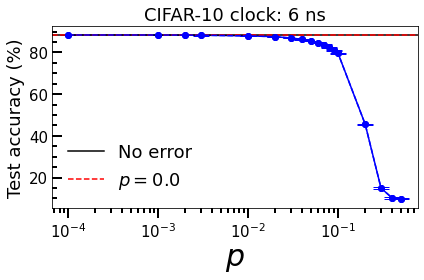

In [8]:
#Plotting the result
plot_params()

plt.plot(p_list[1:], acc_mean_all_6_ns[1:], 'bo-')
plt.errorbar(p_list[1:], acc_mean_all_6_ns[1:], yerr=acc_std_all_6_ns[1:], fmt='--bo',capsize=8, elinewidth=1.1, markeredgewidth=1);
plt.xscale('log');
plt.ylabel("Test accuracy (%)", size=18);
plt.xlabel("$p$", size=30);
plt.axhline(y=88.3, color='black', linestyle='-', label='No error');
plt.axhline(y=acc_mean_all_6_ns[0], color='red', linestyle='--', label='$p=0.0$');
plt.title("CIFAR-10 clock: 6 ns", size=18);
plt.legend(loc='lower left', frameon=False, prop={'size':18});
plt.tight_layout()